# Introduction


# QKNA

# Workflow


In [113]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
import os
import subprocess as subp
import re

In [303]:
# Parameters

# Files
data_file = 'samples_A.csv'

# Paths
data_path = '../../00_Datasets/' 
work_path = './working/'
gsl_path = '../../90_GSL_exe/'

# Proportion of grid blocks to test
prop_test =0.1

# Estimation Grid
griddef = {'xorig':10,
           'xsize':20,
           'nx':50,
           'yorig':10,
           'ysize':20,
           'ny':50,
           'zorig':5,
           'zsize':10,
           'zx':5,
           }




# Housekeeping
## Create the working directory
if not os.path.exists(work_path):
    # Create the subdirectory
    os.makedirs(work_path)



In [253]:
# Functions
def GSLIB2Dataframe(data_file):
    """Convert GSLIB Geo-EAS files to a pandas DataFrame for use with Python
    methods.
    data_file: dataframe
    """

    columns = []
    with open(data_file) as f:
        head = [next(f) for _ in range(2)]  # read first two lines
        line2 = head[1].split()
        ncol = int(line2[0])  # get the number of columns

        for icol in range(ncol):  # read over the column names
            head = next(f)
            columns.append(head.split()[0])

        data = np.loadtxt(f, skiprows=0)
        df = pd.DataFrame(data)
        df.columns = columns
        return df     

def Dataframe2GSLIB(data_file, df):
    """Convert pandas DataFrame to a GSLIB Geo-EAS file for use with GSLIB
    methods.
    data_file: file name
    df: dataframe
    """
    ncol = len(df.columns)
    nrow = len(df.index)

    with open(data_file, "w") as f:
        f.write(data_file + "\n")
        f.write(str(ncol) + "\n")

        for icol in range(ncol):
            f.write(df.columns[icol] + "\n")
        for irow in range(nrow):
            for icol in range(ncol):
                f.write(str(df.iloc[irow, icol]) + " ")
            f.write("\n")

def gamv_to_df(out_file):
    """Convert GSLIB gamv output to a pandas DataFrame for use with Python
    methods.
    out_file: file name
    df: dataframe
    """
    with open(out_file, 'r') as file:
        direction =0
        all_lags = []

        for line in file: 
            if "Semivariogram" in line:
                direction = direction + 1
                pass
            else:
                # Extract numeric values from the line and convert them to floats
                numeric_values = [float(num) for num in
                                re.findall(r"[-+]?\d*\.\d+|\d+", line)]
                if numeric_values[0] !=1: 
                    numeric_values.insert(0, direction)
                    all_lags.append(numeric_values)

        df = pd.DataFrame(all_lags, columns=['direction', 'lag', 'mn_lagd',
                                            'semivariance','n_pairs','mn_tail', 'mn_head',])
        return df
    
def run_gsl(exe_path,par_path,print_stdout=False):
    """Run a GSLIB executable with a parameter file."""
    result = subp.run([exe_path, par_path,],
                      stdout=subp.PIPE) 
    if print_stdout:
        print(result.stdout.decode())
    else:    
        if result.returncode == 0:
            print("Run successful")
        else:
            print("Run failed")
            print("STDOUT:", result.stdout.decode())   

def vmod_to_df(out_file):
    """Convert GSLIB vmod output to a pandas DataFrame for use with Python
    methods.
    out_file: file name
    df: dataframe
    """
    with open(out_file, 'r') as file:
        direction =0
        all_lags = []

        for line in file: 
            if "Model Variogram" in line:
                direction = direction + 1
                pass
            else:
                # Extract numeric values from the line and convert them to floats
                numeric_values = [float(num) for num in
                                re.findall(r"[-+]?\d*\.\d+|\d+", line)]
                if numeric_values[2] !=0: 
                    numeric_values.insert(0, direction)
                    all_lags.append(numeric_values)

    df = pd.DataFrame(all_lags, columns=['direction', 'lag', 'lagd',
                                        'semivariance','dummy','1-semivar', 'std_semivar',])
    return df             


In [73]:
#Import the data
# Load the sample data
samples = pd.read_csv(f'{data_path}{data_file}')
display(samples.head())

# Save data to working directory
Dataframe2GSLIB(f'{work_path}samples.dat', samples)


,x,y,z,al2o3,fe,k2o,p,rd,sio2
0,309.5,369.5,49.0,0.806642,63.892740,0.024624,0.035418,4.762571,3.850990
1,309.5,369.5,48.0,0.723856,66.212017,0.032124,0.042126,4.800028,2.258230
2,309.5,369.5,47.0,0.629985,67.787588,0.038719,0.060582,4.977137,0.648399
3,309.5,369.5,46.0,1.518784,65.867975,0.171313,0.040055,4.756381,2.449109
4,309.5,369.5,45.0,1.601572,64.405999,0.356946,0.060760,4.676700,2.770057


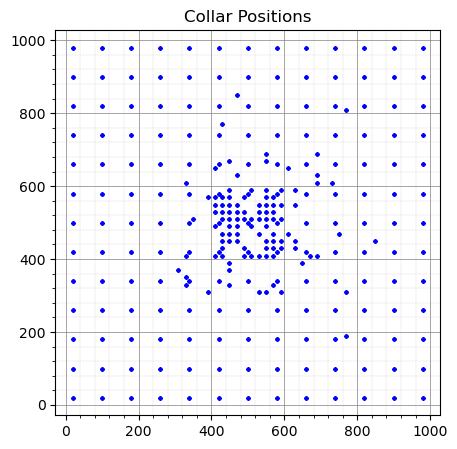

In [53]:
# Location Plot

fig,ax = plt.subplots(figsize =(5,5))
ax.scatter(samples['x'], samples['y'], color='blue',s=2)
plt.gca().set_aspect('equal')
plt.grid(True, which='major', linestyle='-', linewidth='.5', color='gray')
plt.grid(True, which='minor', linestyle=':', linewidth='0.2', color='gray')
ax.xaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
plt.title('Collar Positions')
plt.show()


## Sample Statistics

,count,mean,std,min,25%,50%,75%,max
al2o3,13600.0,1.182881,1.478709,0.090000,0.697683,0.958634,1.284685,33.981192
fe,13600.0,64.898642,5.282172,9.154956,64.720537,66.060056,66.970031,69.669441
k2o,13600.0,0.213358,0.379762,0.001047,0.077031,0.147535,0.249497,8.768663
p,13600.0,0.073064,0.034007,0.010032,0.052641,0.065077,0.083162,0.415000
rd,13600.0,4.819766,0.251098,2.804879,4.757810,4.862159,4.951714,5.360000
sio2,13600.0,4.045735,6.157371,0.392000,1.873889,2.609246,3.787592,82.420000


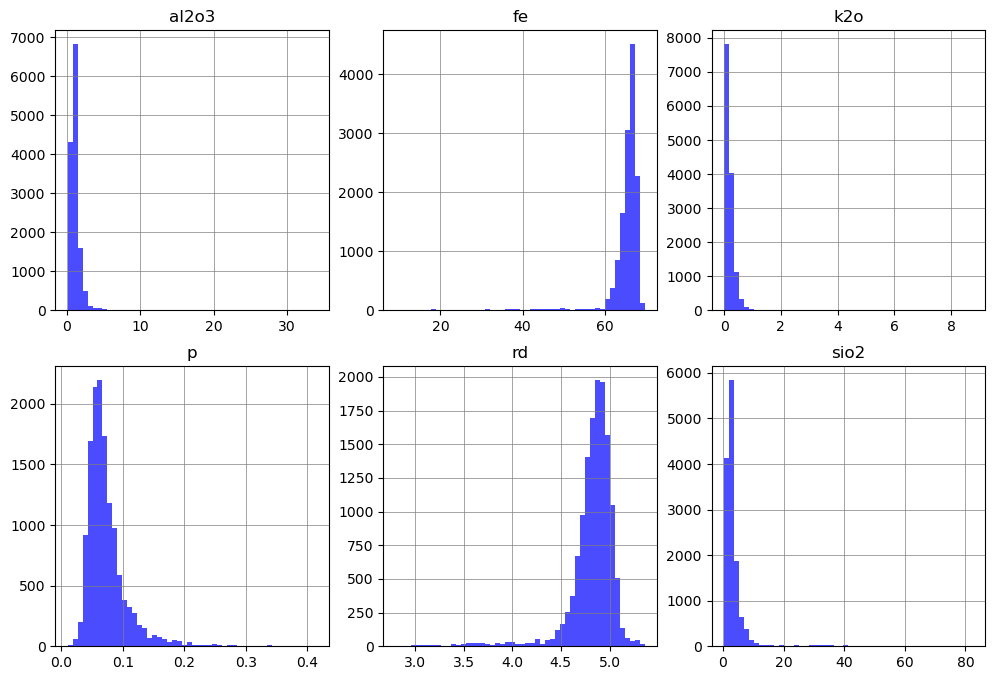

In [55]:
# Statistics and Histograms
varlist = ['al2o3','fe','k2o','p','rd','sio2']
display(samples[varlist].describe().T)

fig,ax = plt.subplots(2,3,figsize=(12,8))
for i, var in enumerate(varlist):
    ax.flatten()[i].hist(samples[var], bins=50, color='blue', alpha=0.7)
    ax.flatten()[i].set_title(var)
    ax.flatten()[i].grid(True, which='major', linestyle='-', linewidth='.5', color='gray')
    ax.flatten()[i].grid(True, which='minor', linestyle=':', linewidth='0.2', color='gray')


## Variography


In [280]:
vardir=['0/0','45/0','90/0','135/0','0/90']

par_gamv_hz = '''
                  Parameters for GAMV
                  *******************

START OF PARAMETERS:
./working/samples.dat                      -file with data
1   2   3                         -   columns for X, Y, Z coordinates
1   5   4                         -   number of variables,col numbers
60     1.0e21                -   trimming limits
./working/gamv_hz.out                          -file for variogram output
20                                -number of lags
40.0                               -lag separation distance
40.0                               -lag tolerance
4                                 -number of directions
0.0    22.5 400.0   0.0  60.0  10.0  -azm,atol,bandh,dip,dtol,bandv
45.0   22.5 400.0   0.0  60.0  10.0  -azm,atol,bandh,dip,dtol,bandv
90.0   22.5 400.0   0.0  60.0  10.0  -azm,atol,bandh,dip,dtol,bandv
135.0  22.5 400.0   0.0  60.0  10.0  -azm,atol,bandh,dip,dtol,bandv
0                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variograms
1   1   1                         -tail var., head var., variogram type
'''

par_gamv_vt = '''
                  Parameters for GAMV
                  *******************

START OF PARAMETERS:
./working/samples.dat                       -file with data
1   2   3                         -   columns for X, Y, Z coordinates
1   5   4                         -   number of variables,col numbers
60     1.0e21                -   trimming limits
./working/gamv_vt.out                          -file for variogram output
30                                -number of lags
1.0                               -lag separation distance
.5                              -lag tolerance
1                                 -number of directions
0.0    90 10.0   90.0  60.0  10.0  -azm,atol,bandh,dip,dtol,bandv
0                                 -standardize sills? (0=no, 1=yes)
1                                 -number of variograms
1   1   1                         -tail var., head var., variogram type
'''

# Save parameter file 
with open(f'{work_path}gamv_hz.par', 'w') as f:
    f.write(par_gamv_hz)

with open(f'{work_path}gamv_vt.par', 'w') as f:
    f.write(par_gamv_vt)    

# Run
run_gsl(f'{gsl_path}gamv.exe',f'{work_path}gamv_hz.par',print_stdout=False)
run_gsl(f'{gsl_path}gamv.exe',f'{work_path}gamv_vt.par',print_stdout=False)

exvg_hz = gamv_to_df('./working/gamv_hz.out')
exvg_vt = gamv_to_df('./working/gamv_vt.out')
exvg_vt['direction'] = 5
exvg = pd.concat([exvg_hz, exvg_vt], axis=0)
del exvg_hz, exvg_vt

Run successful
Run successful


In [301]:
varmod = """
2    1.353                               -  nst, nugget effect
2    0.833 123.7   0.0   0.0             -  it,cc,ang1,ang2,ang3
        31.975       34.715       28.321 -  a_hmax,a_hmin,a_vert
2    0.479 123.7   0.0   0.0             -  it,cc,ang1,ang2,ang3
       289.290      216.450      106.790 -  a_hmax,a_hmin,a_vert
"""

par_varmodel = '''
                  Parameters for VMODEL
                  *********************

START OF PARAMETERS:
./working/vmodel.out                     -file for variogram output
5   40                         -number of directions and lags
0.0     0.0    20              -azm, dip, lag distance
45.0    0.0    20              -azm, dip, lag distance
90.0    0.0    20              -azm, dip, lag distance
135.0   0.0    20              -azm, dip, lag distance
90.0    0.0    1               -azm, dip, lag distance
**varmod**
'''

# replace **varmod*** with the variogram model
par_varmodel = par_varmodel.replace('**varmod**', varmod)
# Save par file
with open(f'{work_path}vmodel.par', 'w') as f:
    f.write(par_varmodel)
# Run
run_gsl(f'{gsl_path}vmodel.exe',f'{work_path}vmodel.par',print_stdout=False)

#Vmod to df
vmod = vmod_to_df('./working/vmodel.out')

Run successful


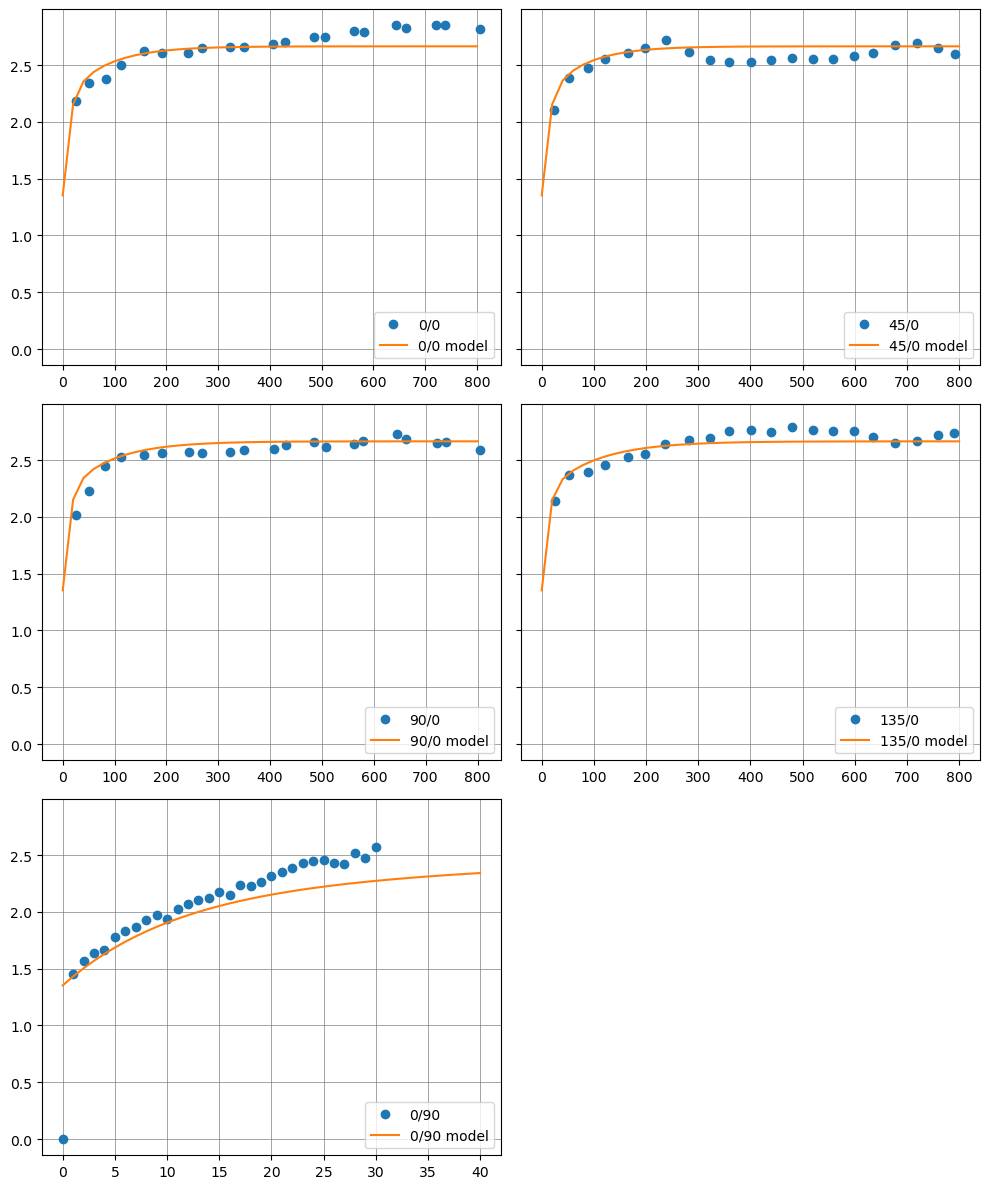

In [302]:
fig,ax = plt.subplots(3,2,figsize=(10,12),sharey=True)
for idx, dir in enumerate(vardir):
    df_exp = exvg[exvg['direction'] == idx+1]
    df_mod = vmod[vmod['direction'] == idx+1]
    ax.flatten()[idx].plot(df_exp['mn_lagd'], df_exp['semivariance'], 'o', label=f'{dir}')
    ax.flatten()[idx].plot(df_mod['lagd'], df_mod['semivariance'], '-', label=f'{dir} model')
    ax.flatten()[idx].legend(loc="lower right")
    ax.flatten()[idx].grid(True, which='major', linestyle='-', linewidth='.5', color='gray')
    ax.flatten()[idx].grid(True, which='minor', linestyle=':', linewidth='0.2', color='gray')
ax.flatten()[idx+1].axis('off')  
fig.tight_layout()  

# QKNA  

* 


In [311]:
# Set up estimation mask
ngrid = griddef['nx']*griddef['ny']*griddef['zx']
mask = pd.DataFrame(np.random.choice([0,1],
                    ngrid,
                    p=[1-prop_test,prop_test]),
                    columns=['mask']) 
# Save mask to working directory
Dataframe2GSLIB(f'{work_path}mask.dat', mask)
